In [15]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal
import contextily
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [35]:
hilo_full = pd.read_parquet('hilo_full_patterns.parquet')

In [46]:
# Restructure the dataset so each row represents a place visit

# Make a subset of the dataset
columns_to_keep = ['placekey', 'location_name', 'latitude', 'longitude', 'raw_visit_counts', 'raw_visitor_counts', 'related_same_day_brand', 'date_range_start']
df_subset = hilo_full[columns_to_keep].copy()

# Fill NaNs in the raw_visit_counts column with zero and make all entries in that column integers 
df_subset['raw_visit_counts'] = pd.to_numeric(df_subset['raw_visit_counts'], errors='coerce').fillna(0).astype(int)

# Use repeat to expand the DataFrame
expanded_df = df_subset.loc[df_subset.index.repeat(df_subset['raw_visit_counts'])].reset_index(drop=True)

In [55]:
import pandas as pd
import argparse

def split_into_months(df):
    """
    Takes a city foot traffic dataframe and splits it into 12 dataframes,
    one for each month of the year.
    """
    df['month'] = df['date_range_start'].str[5:7].astype("Int64")  # Extract month from the date
    months = {}
    for month in range(1, 13):
        months[month] = df[df['month'] == month]
    return months

for month, month_df in month_dfs.items():
    month_df.to_csv(f"output_month_{month:02d}.csv", index=False)

In [9]:
def dbscan_clustering(data, eps=0.01, min_samples=10, plot=False):
    """
    Perform DBSCAN clustering on provided geographic data.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing the longitude and latitude columns.
    - eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    - min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.
    - plot (bool): If True, plot the clustering result on a map.
    
    Returns:
    - pd.Series: Cluster labels for each point in the DataFrame.
    """
    # Perform DBSCAN clustering
    clusterer = DBSCAN(eps=eps, min_samples=min_samples, algorithm='auto')
    labels = clusterer.fit_predict(data[['longitude', 'latitude']])
    labels_series = pd.Series(labels, index=data.index)
    
    # Plotting
    if plot:
        f, ax = plt.subplots(1, figsize=(16, 12), dpi=100)
        
        # Subset points that are not part of any cluster (noise)
        noise = data.loc[labels_series == -1, ['longitude', 'latitude']]
        clusters = data.loc[labels_series != -1, ['longitude', 'latitude']]
        
        # Plot clusters
        scatter = ax.scatter(clusters['longitude'], clusters['latitude'], c=labels_series[labels_series != -1], s=5, cmap='viridis', linewidth=0)
        # Plot noise in grey
        ax.scatter(noise['longitude'], noise['latitude'], color='grey', s=5, linewidth=0)
        
        # Add colorbar
        plt.colorbar(scatter, ax=ax, label='Cluster Label')
        
        # Add basemap
        contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron, crs='EPSG:4326')
        ax.set_axis_off()
        plt.show()

    return labels_series

In [12]:
# Check expanded_df for missing or infinite values and drop them if necessary
expanded_df = expanded_df.dropna(subset=['longitude', 'latitude'])
expanded_df = expanded_df[(expanded_df['longitude'] != np.inf) & (expanded_df['latitude'] != np.inf)]
expanded_df = expanded_df[(expanded_df['longitude'] != -np.inf) & (expanded_df['latitude'] != -np.inf)]

In [11]:
hilo_full = hilo_full.dropna(subset=['longitude', 'latitude'])

In [34]:
#dbscan_clustering(hilo_full)

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import utm
import hdbscan
import os
import contextily as ctx
import numpy as np

In [25]:
def perform_hdbscan(data, min_cluster_size, min_samples, filename, save_output=True):
    """
    Perform HDBSCAN clustering on provided geographic data and save the results.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing the longitude and latitude columns.
    - min_cluster_size (int): The minimum size of clusters; not less than this number of points will form a cluster.
    - min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point. This helps control the degree of noise.
    - filename (str): The name of the file to save the clusters.
    - save_output (bool): Whether to save the clustering output to a file.
    
    Returns:
    - gpd.GeoDataFrame: GeoDataFrame with cluster labels.
    """

    # Clean and sample dataset
    data = data.dropna(subset=['longitude', 'latitude'])
    #data = data.sample(n=100000, random_state=42)  # Sample 100,000 points randomly

    # Convert DataFrame to GeoDataFrame with longitude and latitude
    gdf = gpd.GeoDataFrame(
        data,
        geometry=gpd.points_from_xy(data.longitude, data.latitude),
        crs='EPSG:4326'
    )

    # Convert from geographic to UTM coordinates for accurate distance measurement
    median_zone_number = int(gdf['geometry'].apply(lambda x: utm.latlon_to_zone_number(x.y, x.x)).median())
    utm_crs = f'+proj=utm +zone={median_zone_number} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
    gdf = gdf.to_crs(utm_crs)

    # Perform HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    labels = clusterer.fit_predict(pd.DataFrame({'x': gdf.geometry.x, 'y': gdf.geometry.y}))
    gdf['cluster'] = labels
    
    if save_output:
        # Define the directory where the files will be saved
        save_directory = "data/foot-traffic/output"
        
        # Full path for saving the file
        save_path = os.path.join(save_directory, filename)

        # Save output to GeoJSON
        gdf.to_file(save_path, driver='GeoJSON')

    return gdf, utm_crs

In [26]:
def summarize_clusters(gdf):
    """
    Summarizes the clusters in a GeoDataFrame that includes a 'cluster' label column.

    Parameters:
    - gdf (gpd.GeoDataFrame): GeoDataFrame with a 'cluster' column where -1 indicates noise.
    
    Returns:
    - pd.DataFrame: DataFrame where each row represents a cluster with columns for the
                    number of points in the cluster, the cluster label, and the centroid geometry.
    """
    # Filter out the noise points
    clusters = gdf[gdf['cluster'] != -1]

    if clusters.empty:
        return pd.DataFrame(columns=['cluster_label', 'num_points', 'geometry'])

    # Group by cluster label
    grouped = clusters.groupby('cluster')

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'num_points': grouped.size(),  # Count points per cluster
        'centroid': grouped['geometry'].apply(lambda x: x.unary_union.centroid)  # Calculate centroid
    }).reset_index()

    # Rename columns appropriately
    summary_df.columns = ['cluster_label', 'num_points', 'geometry']

    return summary_df

In [79]:
def plot_cluster_centroids(cluster_summary_df, utm_crs):
    """
    Plots the centroids of clusters on a map, annotating each centroid with the number of points in the cluster,
    and overlays this on a basemap for geographical context.
    
    Parameters:
    - cluster_summary_df (pd.DataFrame): DataFrame with columns 'cluster_label', 'num_points', and 'geometry' (centroids).
    """
    # Assuming the centroid geometries are in latitude and longitude
    gdf = gpd.GeoDataFrame(cluster_summary_df, geometry='geometry', crs=utm_crs)

    # Check and handle NaNs or infinite values
    if gdf.isna().any().any():
        gdf.dropna(inplace=True)  # Drop NaNs

    # Convert CRS to EPSG:3857 for contextily
    gdf = gdf.to_crs(epsg=3857)

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Adjust marker size based on the number of points, ensuring visibility
    marker_sizes = gdf['num_points'] / gdf['num_points'].max() * 100  # Scale marker size

    # Plot each centroid
    gdf.plot(ax=ax, color='blue', markersize=marker_sizes, alpha=0.6)

    # Annotate the centroid with the number of points in the cluster
    for idx, row in gdf.iterrows():
        ax.text(row.geometry.x, row.geometry.y, f'{row["num_points"]}', fontsize=8, ha='left')

    # Add a basemap with adjusted zoom if needed
    try:
        ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
    except ValueError:
        # Handle potential ValueError if zoom level is too high
        ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)  # A more reasonable, fixed zoom level

    # Set plot parameters
    ax.set_title('Cluster Centroids with Number of Points')
    ax.axis('off') 

    plt.show()

In [ ]:
# Perform clustering
data = pd.read_csv("output_month_05.csv")
    
clustered_gdf, utm_crs = perform_hdbscan(data, min_cluster_size=50, min_samples=20, filename= 'hilo_cluster_month_05.geojson', save_output=False)

# Restructure dataset and get centroids
cluster_summary = summarize_clusters(clustered_gdf)
print(cluster_summary)

     cluster_label  num_points                        geometry
0                0         135  POINT (289326.361 2174797.911)
1                1         155  POINT (282561.117 2174425.881)
2                2          64  POINT (276601.453 2178237.965)
3                3          64  POINT (276214.869 2178214.247)
4                4          68  POINT (276068.068 2181790.575)
..             ...         ...                             ...
452            452          65  POINT (281331.179 2182445.292)
453            453         100  POINT (283385.207 2179751.662)
454            454          61  POINT (283396.988 2179823.529)
455            455          75  POINT (282137.206 2181384.241)
456            456         125  POINT (282120.886 2181407.325)

[457 rows x 3 columns]


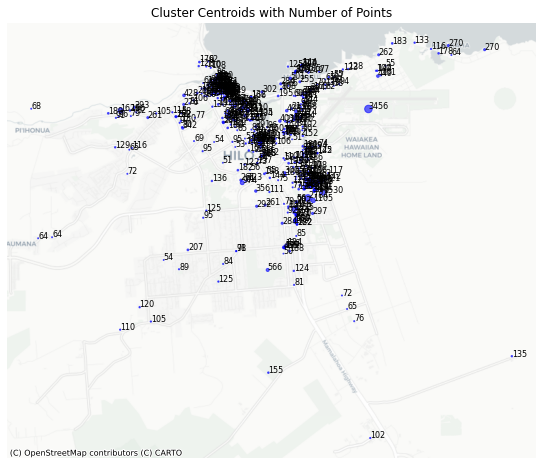

In [ ]:
# Plot the cluster centroids 
# For May from 2018-2021
plot_cluster_centroids(cluster_summary, utm_crs)

     cluster_label  num_points                        geometry
0                0           6  POINT (281721.851 2167897.199)
1                1          40  POINT (258495.032 2163207.040)
2                2          11  POINT (258695.667 2163512.322)
3                3         151  POINT (289326.361 2174797.911)
4                4           8  POINT (273367.335 2177289.049)
..             ...         ...                             ...
773            773          29  POINT (281176.876 2182457.377)
774            774         125  POINT (281405.771 2182303.489)
775            775          21  POINT (281403.855 2182292.698)
776            776          18  POINT (281394.073 2182290.160)
777            777          24  POINT (281395.634 2182280.674)

[778 rows x 3 columns]


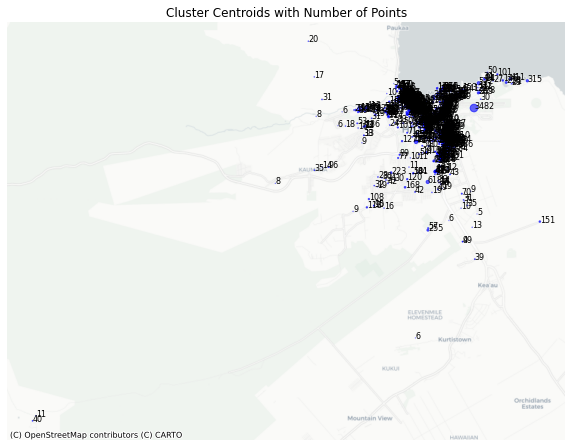

In [65]:
# Perform clustering
data = pd.read_csv("output_month_06.csv")
    
clustered_gdf, utm_crs = perform_hdbscan(data, min_cluster_size=5, min_samples=5, filename= 'hilo_cluster_month_06.geojson', save_output=False)

# Restructure dataset and get centroids
cluster_summary = summarize_clusters(clustered_gdf)
print(cluster_summary)

plot_cluster_centroids(cluster_summary, utm_crs)

In [ ]:
def plot_clusters(summary_df, filename):
    gdf = gpd.GeoDataFrame(summary_df, geometry='geometry', crs="EPSG:4326")
    gdf = gdf.to_crs(epsg=3857)

    # Filtering out non-finite values
    gdf = gdf[gdf['geometry'].x.notnull() & gdf['geometry'].y.notnull()]
    gdf = gdf[(gdf['geometry'].x != np.inf) & (gdf['geometry'].x != -np.inf)]
    gdf = gdf[(gdf['geometry'].y != np.inf) & (gdf['geometry'].y != -np.inf)]

    fig, ax = plt.subplots(1, figsize=(10, 8))
    gdf.plot(ax=ax, markersize=5, color='blue')  # Adjust marker size appropriately

    # Manually setting zoom level
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=10)

    plt.savefig(filename)
    plt.show()

In [82]:
# Example usage (assuming 'summary_df' is already computed and available):
# plot_clusters(summary_df, 'cluster_centroids.png')

In [ ]:
def batch_cluster_and_plot(data, eps_range, num_batches):
    """
    Execute clustering and plotting for various eps and min_samples values.
    """
    batch_size = max(int(len(data) * 0.01), 1)
    min_samples_range = range(batch_size, batch_size * (num_batches + 1), batch_size)

    for eps in eps_range:
        for min_samples in min_samples_range:
            gdf = perform_hdbscan(data, eps, min_samples)
            plot_path = f'hilo_dbscan_eps{eps}_min{min_samples}.png'
            plot_clusters(gdf, eps, min_samples, plot_path)

In [83]:
#data = pd.read_csv("data/foot-traffic/output/hilo_seasonal_fall.csv")

# Perform clustering
#clustered_gdf = perform_hdbscan(data, min_cluster_size=100, min_samples=20, filename='hilo_fall_clusters.geojson', save_output=False)

# Restructure dataset and get centroids
#cluster_summary = summarize_clusters(clustered_gdf)
#print(cluster_summary)

# Plot the cluster centroids 
# Currently only shows an empty graph
#plot_cluster_centroids(cluster_summary)

# Plot the clusters and save - doesn't work
# plot_clusters(cluster_summary, "hilo_fall.png")

# Not functioning yet - plots a variety of graphs
#eps_range= [500, 1000, 2000, 3000]
#num_batches = 5
#batch_cluster_and_plot(data_cleaned, eps_range, num_batches)